In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)

Statcast CSV Doc: https://baseballsavant.mlb.com/csv-docs

1. group pitch type
1. add handedness column
1. calculate contact profile stats
1. calculate player level stats

In [3]:
raw_19 = pd.read_csv('../data/PitchData_19.csv')
raw_20 = pd.read_csv('../data/PitchData_20.csv')
raw_21 = pd.read_csv('../data/PitchData_21.csv')

In [4]:
raw_all = pd.concat([raw_21, raw_20, raw_19], ignore_index=True)

In [5]:
data = raw_all.copy()

In [6]:
data.drop(columns=data.columns[0], inplace=True)

In [7]:
data.shape

(1803348, 92)

In [8]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FF,2021-11-02,93.7,1.39,6.72,"Smith, Will",493329,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,5.0,"Yuli Gurriel grounds out, shortstop Dansby Swa...",W,R,L,HOU,ATL,X,6.0,ground_ball,0,2,2021,0.57,1.21,0.19,2.68,NaN,NaN,488726.0,2,9,Bot,98.12,136.43,NaN,NaN,518595.0,NaN,NaN,-4.348927,-136.263269,-7.335202,8.101619,29.384843,-15.743652,3.37,1.53,5.0,93.8,-28.0,93.4,2112.0,6.1,660906,519293,518595.0,518692.0,645277.0,663586.0,621020.0,592696.0,628338.0,594807.0,54.39,0.071,0.064,0.0,1.0,0.0,0.0,2.0,69,3,4-Seam Fastball,0,7,0,7,7,0,0,7,Standard,Standard,146.0,0.000,-0.138
1,FF,2021-11-02,92.9,1.38,6.72,"Smith, Will",493329,519293,NaN,foul,NaN,NaN,NaN,NaN,5.0,"Yuli Gurriel grounds out, shortstop Dansby Swa...",W,R,L,HOU,ATL,S,NaN,NaN,0,1,2021,0.90,1.34,0.01,2.12,NaN,NaN,488726.0,2,9,Bot,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-5.455433,-134.989926,-8.881689,12.188852,30.690010,-14.009571,3.37,1.53,156.0,75.0,15.0,92.6,2206.0,6.3,660906,519293,518595.0,518692.0,645277.0,663586.0,621020.0,592696.0,628338.0,594807.0,54.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,2,4-Seam Fastball,0,7,0,7,7,0,0,7,Standard,Standard,145.0,0.000,-0.047
2,FF,2021-11-02,93.1,1.35,6.73,"Smith, Will",493329,519293,NaN,called_strike,NaN,NaN,NaN,NaN,6.0,"Yuli Gurriel grounds out, shortstop Dansby Swa...",W,R,L,HOU,ATL,S,NaN,NaN,0,0,2021,0.81,1.52,0.78,2.13,NaN,NaN,488726.0,2,9,Bot,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-3.230974,-135.201801,-9.255781,10.678480,31.699974,-11.705800,3.40,1.53,NaN,NaN,NaN,92.5,2216.0,6.2,660906,519293,518595.0,518692.0,645277.0,663586.0,621020.0,592696.0,628338.0,594807.0,54.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,1,4-Seam Fastball,0,7,0,7,7,0,0,7,Standard,Standard,143.0,0.000,-0.042
3,FF,2021-11-02,94.6,1.31,6.73,"Smith, Will",670541,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,5.0,Yordan Alvarez flies out to left fielder Eddie...,W,L,L,HOU,ATL,X,7.0,fly_ball,3,2,2021,0.85,1.27,-0.23,2.66,NaN,NaN,488726.0,1,9,Bot,68.50,86.79,NaN,NaN,518595.0,NaN,NaN,-5.901934,-137.422092,-7.652311,12.118242,35.102245,-14.577857,3.58,1.68,312.0,92.7,39.0,93.8,2263.0,6.3,660906,519293,518595.0,518692.0,645277.0,663586.0,621020.0,592696.0,628338.0,594807.0,54.25,0.026,0.046,0.0,1.0,0.0,0.0,3.0,68,6,4-Seam Fastball,0,7,0,7,7,0,0,7,Infield shift,Standard,140.0,-0.001,-0.386
4,FF,2021-11-02,93.6,1.31,6.80,"Smith, Will",670541,519293,NaN,ball,NaN,NaN,NaN,NaN,13.0,Yordan Alvarez flies out to left fielder Eddie...,W,L,L,HOU,ATL,B,NaN,NaN,2,2,2021,0.90,1.43,-1.15,1.51,NaN,NaN,488726.0,1,9,Bot,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-8.265487,-135.578023,-10.936295,12.932808,31.370147,-12.168466,3.46,1.68,NaN,NaN,NaN,92.8,2239.0,6.2,660906,519293,518595.0,518692.0,645277.0,663586.0,621020.0,592696.0,628338.0,594807.0,54.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68,5,4-Seam Fastball,0,7,0,7,7,0,0,7,Infield shift,Standard,152.0,0.000,0.120


keep only regular season games

In [9]:
data = data[data['game_type']=='R'].copy()
data.shape

(1705908, 92)

seperate last month of 2021

In [224]:
data_test_full = data[data['game_date']>='2021-09-01'].copy()
data_train_full = data[data['game_date']<'2021-09-01'].copy()

# remove all pitchers with less than 200 pitches thrown (~50 PA)

In [11]:
pitch_count = data_train_full['pitcher'].value_counts().rename_axis('pitcher').reset_index(name='count').copy()

In [12]:
# number of pitchers with less than 200 Pit
pitch_count[pitch_count['count']<200].shape

(302, 2)

In [13]:
remove_list = pitch_count[pitch_count['count']<200]['pitcher'].to_list()

In [14]:
data_train_full = data_train_full.loc[~data_train_full['pitcher'].isin(remove_list)].copy()

# check NAN

In [15]:
check_var = ['pitch_type','release_spin_rate', 'release_pos_x',
             'release_pos_y','release_speed', 'pfx_x', 'pfx_z', 'spin_axis']

In [16]:
data_train_full[check_var].isna().sum()

pitch_type            5989
release_spin_rate    23352
release_pos_x         7750
release_pos_y         7750
release_speed         7549
pfx_x                 7540
pfx_z                 7540
spin_axis            11178
dtype: int64

These NANs are mostly mutually inclusive, so I will drop all of them

In [17]:
# drop all nan
data_train = data_train_full.dropna(subset=check_var, how='any').copy()


In [18]:
# check NAN again
data_train[check_var].isna().sum()

pitch_type           0
release_spin_rate    0
release_pos_x        0
release_pos_y        0
release_speed        0
pfx_x                0
pfx_z                0
spin_axis            0
dtype: int64

In [19]:
data_train.shape

(1531221, 92)

# group pitch type

In [20]:
# see what pitch types there are
data_train['pitch_type'].unique()

array(['CH', 'FF', 'SL', 'CU', 'KC', 'SI', 'FC', 'CS', 'FS', 'FA', 'EP'],
      dtype=object)

In [21]:
data_train['pitch_name'].unique()

array(['Changeup', '4-Seam Fastball', 'Slider', 'Curveball',
       'Knuckle Curve', 'Sinker', 'Cutter', 'Split-Finger', 'Fastball',
       'Eephus'], dtype=object)

In [22]:
data_train['pitch_type'].value_counts()

FF    547559
SL    271020
SI    245798
CH    173175
CU    132325
FC    103613
KC     33643
FS     23452
CS       516
FA        66
EP        54
Name: pitch_type, dtype: int64

Group By:

Fastball: FF

Moving Fastball: SI

Slider/Cutter: SL, FC

Curve: CU, KC, CS

Off-speed: CH, FS, FO

other: FA, KN, EP, SC

In [23]:
pitch_group = {'FF':'fastball', 'SI':'fastball', 'SL':'sli_cut', 'FC':'sli_cut', 'CU':'curve',
              'KC':'curve', 'CS':'curve', 'CH':'off_speed', 'FS':'off_speed', 'FO':'off_speed',
              'FA':'other', 'KN':'other', 'EP':'other', 'SC':'other'}

In [24]:
# add group label
for index, row in data_train.iterrows():
    data_train.at[index, 'pitch_group'] = pitch_group[row.pitch_type]

# drop others

In [25]:
data_train = data_train[data_train['pitch_group']!='other'].copy()

In [26]:
# add handedness label
data_train['handedness_right1'] = 0
data_train.loc[data_train['p_throws']=='R', 'handedness_right1'] = 1

# group data

In [27]:
# group by pitcher
data_pitcher = data_train.groupby(['pitcher']).agg({'player_name':max, 'handedness_right1':max,
                                                  'release_pos_x':'mean', 'release_pos_z':'mean'})
data_pitcher.reset_index(inplace=True)

In [28]:
print(data_pitcher.shape)
data_pitcher.head()

(916, 5)


,pitcher,player_name,handedness_right1,release_pos_x,release_pos_z
0,282332,"Sabathia, CC",0,2.315865,5.899743
1,407845,"Rodney, Fernando",1,-2.164653,6.046254
2,424144,"Pérez, Oliver",0,2.475649,5.331951
3,425794,"Wainwright, Adam",1,-1.339804,6.171098
4,425844,"Greinke, Zack",1,-1.269014,6.336909


In [29]:
# # create dummies for pitch group to calcualte percentage
# dummies = pd.get_dummies(data_train['pitch_group'])
# data_train = pd.concat((data_train, dummies), axis=1)

In [30]:
data_train.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,pitch_group,handedness_right1
141676,CH,2021-08-31,84.4,-1.87,5.94,"Sulser, Cole",502481,642121,strikeout,swinging_strike,NaN,NaN,NaN,NaN,7.0,Jarrod Dyson strikes out swinging.,R,L,R,TOR,BAL,S,2.0,NaN,1,2,2021,-1.13,0.29,-0.35,1.48,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,600474.0,NaN,NaN,5.838764,-122.677355,-4.584518,-12.604605,25.539047,-28.483589,3.29,1.49,NaN,NaN,NaN,84.9,1586.0,6.8,632715,642121,600474.0,663624.0,602104.0,642721.0,622761.0,663630.0,656775.0,669720.0,53.72,NaN,NaN,0.0,1.0,0.0,0.0,NaN,72,4,Changeup,2,4,2,4,4,2,2,4,Standard,Standard,224.0,-0.014,-0.073,off_speed,1
141677,FF,2021-08-31,92.0,-1.58,5.99,"Sulser, Cole",502481,642121,NaN,foul,NaN,NaN,NaN,NaN,12.0,Jarrod Dyson strikes out swinging.,R,L,R,TOR,BAL,S,NaN,NaN,1,1,2021,-0.39,1.70,0.86,3.52,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,600474.0,NaN,NaN,7.066879,-133.615997,-4.003236,-6.393131,33.152666,-11.266612,3.29,1.49,217.0,76.3,49.0,91.7,2209.0,6.5,632715,642121,600474.0,663624.0,602104.0,642721.0,622761.0,663630.0,656775.0,669720.0,53.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,3,4-Seam Fastball,2,4,2,4,4,2,2,4,Standard,Standard,212.0,0.000,-0.027,fastball,1
141678,CH,2021-08-31,83.6,-1.85,5.97,"Sulser, Cole",502481,642121,NaN,ball,NaN,NaN,NaN,NaN,13.0,Jarrod Dyson strikes out swinging.,R,L,R,TOR,BAL,B,NaN,NaN,0,1,2021,-1.32,0.59,-0.35,0.83,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,600474.0,NaN,NaN,6.069779,-121.373133,-6.516427,-14.222209,25.444915,-25.199478,3.48,1.72,NaN,NaN,NaN,83.3,1472.0,6.4,632715,642121,600474.0,663624.0,602104.0,642721.0,622761.0,663630.0,656775.0,669720.0,54.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,2,Changeup,2,4,2,4,4,2,2,4,Standard,Standard,224.0,0.000,0.014,off_speed,1
141679,FF,2021-08-31,92.5,-1.71,6.01,"Sulser, Cole",502481,642121,NaN,called_strike,NaN,NaN,NaN,NaN,5.0,Jarrod Dyson strikes out swinging.,R,L,R,TOR,BAL,S,NaN,NaN,0,0,2021,-0.66,1.48,-0.26,2.74,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,600474.0,NaN,NaN,5.131932,-134.524130,-5.718098,-9.190468,32.087543,-13.145059,3.40,1.61,NaN,NaN,NaN,92.2,2151.0,6.4,632715,642121,600474.0,663624.0,602104.0,642721.0,622761.0,663630.0,656775.0,669720.0,54.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,1,4-Seam Fastball,2,4,2,4,4,2,2,4,Standard,Standard,213.0,0.000,-0.018,fastball,1
141680,FF,2021-08-31,91.9,-1.69,6.03,"Sulser, Cole",672386,642121,field_out,hit_into_play,NaN,NaN,NaN,NaN,8.0,"Alejandro Kirk grounds out sharply, shortstop ...",R,R,R,TOR,BAL,X,6.0,ground_ball,3,1,2021,-0.84,1.33,-0.01,1.73,NaN,NaN,NaN,1,9,Bot,101.11,141.72,NaN,NaN,600474.0,NaN,NaN,6.116742,-133.514842,-7.892097,-11.485549,31.890207,-14.697180,3.26,1.48,9.0,106.0,-11.0,92.1,2116.0,6.7,632715,642121,600474.0,663624.0,602104.0,642721.0,622761.0,663630.0,656775.0,669720.0,53.78,0.317,0.295,0.0,1.0,0.0,0.0,2.0,71,5,4-Seam Fastball,2,4,2,4,4,2,2,4,Standard,Standard,215.0,-0.029,-0.278,fastball,1


In [31]:
# groupby pitcher, pitch_group
data_pitchGroup = data_train.groupby(['pitcher', 'pitch_group']).agg({'release_speed':'mean', 'pfx_x':'mean', 
                                                        'pfx_z':'mean', 'release_spin_rate':'mean', 'spin_axis':'mean'})

In [32]:
# add pitch type count
data_pitchGroup['pitch_type_count'] = 1

In [33]:
data_pitchGroup.head()

release_speed     pfx_x     pfx_z  release_spin_rate  \
pitcher pitch_group                                                         
282332  fastball         89.117407  1.061556  0.718593        2054.900000   
        off_speed        82.674408  0.735024  0.645924        1884.739336   
        sli_cut          84.779244 -0.348042  0.572118        2199.715126   
407845  fastball         93.801906 -0.923969  1.166707        2085.337955   
        off_speed        82.965164 -1.259139  0.643811        1751.614754   

                      spin_axis  pitch_type_count  
pitcher pitch_group                                
282332  fastball     124.774074                 1  
        off_speed    131.938389                 1  
        sli_cut      211.732773                 1  
407845  fastball     218.008666                 1  
        off_speed    242.942623                 1

In [34]:
data_pitchGroup = data_pitchGroup.reset_index().copy()

In [35]:
data_pitchGroup = data_pitchGroup.pivot(index='pitcher', columns=['pitch_group'], values=['release_speed', 'pfx_x', 'pfx_z', 
                                                                                          'release_spin_rate', 'spin_axis'])

In [36]:
num = data_pitchGroup['release_speed']['fastball'].isna().sum()
print(f"Number of non-FF pitcher: {num}")

Number of non-FF pitcher: 1


In [37]:
# fill NA
data_pitchGroup = data_pitchGroup.fillna(0)

In [38]:
data_pitchGroup.reset_index()

pitcher release_speed                                      pfx_x  \
pitch_group                 curve   fastball  off_speed    sli_cut     curve   
0            282332      0.000000  89.117407  82.674408  84.779244  0.000000   
1            407845      0.000000  93.801906  82.965164  86.257143  0.000000   
2            424144      0.000000  90.947259   0.000000  77.725556  0.000000   
3            425794     74.087055  89.483854  82.926754  84.961713  1.451246   
4            425844     70.710516  89.339054  86.774393  83.836519  0.974722   
..              ...           ...        ...        ...        ...       ...   
911          681810      0.000000  93.693458  87.580000  87.117526  0.000000   
912          681911      0.000000  93.298257  85.558333  84.456977  0.000000   
913          683232     78.926357  95.473518   0.000000   0.000000  0.329225   
914          685493     71.250000  90.767647  84.804545  81.617442  1.028333   
915          685503     74.041667  91.013901  82.504950  84.393506  0.782500   

                                              pfx_z                      \
pitch_group  fastball off_speed   sli_cut     curve  fastball off_speed   
0            1.061556  0.735024 -0.348042  0.000000  0.718593  0.645924   
1           -0.923969 -1.259139  0.189286  0.000000  1.166707  0.643811   
2            1.361720  0.000000 -0.771156  0.000000  0.780113  0.000000   
3           -0.803627 -1.164254  0.491259 -1.119364  0.995953  0.648728   
4           -0.231497 -1.056294  0.605986 -0.906631  1.343071  0.347689   
..                ...       ...       ...       ...       ...       ...   
911         -1.008598 -1.306000  0.331031  0.000000  1.164393  0.536000   
912          0.594248  1.163889 -0.534651  0.000000  1.669586  0.929583   
913         -0.362688  0.000000  0.000000 -0.926279  1.551304  0.000000   
914         -0.909755 -0.923788  0.412907 -0.884167  1.298039  0.238838   
915         -0.992018 -0.981980  0.194026 -0.918333  1.226054  0.351980   

                      release_spin_rate                            \
pitch_group   sli_cut             curve     fastball    off_speed   
0            0.572118          0.000000  2054.900000  1884.739336   
1            0.615357          0.000000  2085.337955  1751.614754   
2           -0.076178          0.000000  2145.011342     0.000000   
3            0.507694       2792.212189  2202.035974  1733.600877   
4            0.203008       2404.678676  2284.131419  1692.246357   
..                ...               ...          ...          ...   
911          0.230722          0.000000  2251.775701  1821.400000   
912          0.372791          0.000000  2370.766885  1974.472222   
913          0.000000       2337.434109  2242.130435     0.000000   
914          0.275814       2479.583333  2129.137255  1261.005051   
915          0.337273       2266.416667  2112.260090  1453.148515   

                          spin_axis                                      
pitch_group      sli_cut      curve    fastball   off_speed     sli_cut  
0            2199.715126   0.000000  124.774074  131.938389  211.732773  
1            2253.607143   0.000000  218.008666  242.942623  161.785714  
2            2249.604444   0.000000  123.967864    0.000000  281.397778  
3            2367.300146  50.798043  210.449251  228.030702  147.502928  
4            2439.226358  49.282376  193.472297  238.265094  120.343058  
..                   ...        ...         ...         ...         ...  
911          2583.711340   0.000000  222.168224  241.400000   90.030928  
912          2435.825581   0.000000  155.041394  130.236111  224.732558  
913             0.000000  13.131783  199.739130    0.000000    0.000000  
914          2290.465116  53.833333  224.328431  239.631313  116.372093  
915          2171.292208  40.750000  219.372197  236.019802  151.948052  

[916 rows x 21 columns]

In [39]:
# combine level_0 and level_1 column names
level_0 = data_pitchGroup.columns.get_level_values(0).to_list()
level_1 = data_pitchGroup.columns.get_level_values(1).to_list()

In [40]:
new_names = [level_0[x]+"_"+level_1[x] for x in range(len(level_0))]
new_names

['release_speed_curve',
 'release_speed_fastball',
 'release_speed_off_speed',
 'release_speed_sli_cut',
 'pfx_x_curve',
 'pfx_x_fastball',
 'pfx_x_off_speed',
 'pfx_x_sli_cut',
 'pfx_z_curve',
 'pfx_z_fastball',
 'pfx_z_off_speed',
 'pfx_z_sli_cut',
 'release_spin_rate_curve',
 'release_spin_rate_fastball',
 'release_spin_rate_off_speed',
 'release_spin_rate_sli_cut',
 'spin_axis_curve',
 'spin_axis_fastball',
 'spin_axis_off_speed',
 'spin_axis_sli_cut']

In [41]:
# drop level_0 and reset index
data_pitchGroup = data_pitchGroup.droplevel(1, axis=1)
data_pitchGroup.reset_index(inplace=True)

In [42]:
data_pitchGroup.head()

,pitcher,release_speed,release_speed,release_speed,release_speed,pfx_x,pfx_x,pfx_x,pfx_x,pfx_z,pfx_z,pfx_z,pfx_z,release_spin_rate,release_spin_rate,release_spin_rate,release_spin_rate,spin_axis,spin_axis,spin_axis,spin_axis
0,282332,0.000000,89.117407,82.674408,84.779244,0.000000,1.061556,0.735024,-0.348042,0.000000,0.718593,0.645924,0.572118,0.000000,2054.900000,1884.739336,2199.715126,0.000000,124.774074,131.938389,211.732773
1,407845,0.000000,93.801906,82.965164,86.257143,0.000000,-0.923969,-1.259139,0.189286,0.000000,1.166707,0.643811,0.615357,0.000000,2085.337955,1751.614754,2253.607143,0.000000,218.008666,242.942623,161.785714
2,424144,0.000000,90.947259,0.000000,77.725556,0.000000,1.361720,0.000000,-0.771156,0.000000,0.780113,0.000000,-0.076178,0.000000,2145.011342,0.000000,2249.604444,0.000000,123.967864,0.000000,281.397778
3,425794,74.087055,89.483854,82.926754,84.961713,1.451246,-0.803627,-1.164254,0.491259,-1.119364,0.995953,0.648728,0.507694,2792.212189,2202.035974,1733.600877,2367.300146,50.798043,210.449251,228.030702,147.502928
4,425844,70.710516,89.339054,86.774393,83.836519,0.974722,-0.231497,-1.056294,0.605986,-0.906631,1.343071,0.347689,0.203008,2404.678676,2284.131419,1692.246357,2439.226358,49.282376,193.472297,238.265094,120.343058


In [43]:
new_names = ['pitcher'] + new_names

In [44]:
data_pitchGroup.columns = new_names

In [45]:
data_pitchGroup

,pitcher,release_speed_curve,release_speed_fastball,release_speed_off_speed,release_speed_sli_cut,pfx_x_curve,pfx_x_fastball,pfx_x_off_speed,pfx_x_sli_cut,pfx_z_curve,pfx_z_fastball,pfx_z_off_speed,pfx_z_sli_cut,release_spin_rate_curve,release_spin_rate_fastball,release_spin_rate_off_speed,release_spin_rate_sli_cut,spin_axis_curve,spin_axis_fastball,spin_axis_off_speed,spin_axis_sli_cut
0,282332,0.000000,89.117407,82.674408,84.779244,0.000000,1.061556,0.735024,-0.348042,0.000000,0.718593,0.645924,0.572118,0.000000,2054.900000,1884.739336,2199.715126,0.000000,124.774074,131.938389,211.732773
1,407845,0.000000,93.801906,82.965164,86.257143,0.000000,-0.923969,-1.259139,0.189286,0.000000,1.166707,0.643811,0.615357,0.000000,2085.337955,1751.614754,2253.607143,0.000000,218.008666,242.942623,161.785714
2,424144,0.000000,90.947259,0.000000,77.725556,0.000000,1.361720,0.000000,-0.771156,0.000000,0.780113,0.000000,-0.076178,0.000000,2145.011342,0.000000,2249.604444,0.000000,123.967864,0.000000,281.397778
3,425794,74.087055,89.483854,82.926754,84.961713,1.451246,-0.803627,-1.164254,0.491259,-1.119364,0.995953,0.648728,0.507694,2792.212189,2202.035974,1733.600877,2367.300146,50.798043,210.449251,228.030702,147.502928
4,425844,70.710516,89.339054,86.774393,83.836519,0.974722,-0.231497,-1.056294,0.605986,-0.906631,1.343071,0.347689,0.203008,2404.678676,2284.131419,1692.246357,2439.226358,49.282376,193.472297,238.265094,120.343058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,681810,0.000000,93.693458,87.580000,87.117526,0.000000,-1.008598,-1.306000,0.331031,0.000000,1.164393,0.536000,0.230722,0.000000,2251.775701,1821.400000,2583.711340,0.000000,222.168224,241.400000,90.030928
912,681911,0.000000,93.298257,85.558333,84.456977,0.000000,0.594248,1.163889,-0.534651,0.000000,1.669586,0.929583,0.372791,0.000000,2370.766885,1974.472222,2435.825581,0.000000,155.041394,130.236111,224.732558
913,683232,78.926357,95.473518,0.000000,0.000000,0.329225,-0.362688,0.000000,0.000000,-0.926279,1.551304,0.000000,0.000000,2337.434109,2242.130435,0.000000,0.000000,13.131783,199.739130,0.000000,0.000000
914,685493,71.250000,90.767647,84.804545,81.617442,1.028333,-0.909755,-0.923788,0.412907,-0.884167,1.298039,0.238838,0.275814,2479.583333,2129.137255,1261.005051,2290.465116,53.833333,224.328431,239.631313,116.372093


In [46]:
# # merge pitchGroup with pitcher
# data_merged = data_pitcher.merge(data_pitchGroup, on='pitcher', how='outer')

# contact profile
### get average launch speed

In [47]:
# drop all contact with 2 strikes
# we start with full data set and only drop rows with missing contact info
data_contact = data_train_full.copy()

In [48]:
data_contact.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
141676,CH,2021-08-31,84.4,-1.87,5.94,"Sulser, Cole",502481,642121,strikeout,swinging_strike,NaN,NaN,NaN,NaN,7.0,Jarrod Dyson strikes out swinging.,R,L,R,TOR,BAL,S,2.0,NaN,1,2,2021,-1.13,0.29,-0.35,1.48,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,600474.0,NaN,NaN,5.838764,-122.677355,-4.584518,-12.604605,25.539047,-28.483589,3.29,1.49,NaN,NaN,NaN,84.9,1586.0,6.8,632715,642121,600474.0,663624.0,602104.0,642721.0,622761.0,663630.0,656775.0,669720.0,53.72,NaN,NaN,0.0,1.0,0.0,0.0,NaN,72,4,Changeup,2,4,2,4,4,2,2,4,Standard,Standard,224.0,-0.014,-0.073
141677,FF,2021-08-31,92.0,-1.58,5.99,"Sulser, Cole",502481,642121,NaN,foul,NaN,NaN,NaN,NaN,12.0,Jarrod Dyson strikes out swinging.,R,L,R,TOR,BAL,S,NaN,NaN,1,1,2021,-0.39,1.70,0.86,3.52,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,600474.0,NaN,NaN,7.066879,-133.615997,-4.003236,-6.393131,33.152666,-11.266612,3.29,1.49,217.0,76.3,49.0,91.7,2209.0,6.5,632715,642121,600474.0,663624.0,602104.0,642721.0,622761.0,663630.0,656775.0,669720.0,53.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,3,4-Seam Fastball,2,4,2,4,4,2,2,4,Standard,Standard,212.0,0.000,-0.027
141678,CH,2021-08-31,83.6,-1.85,5.97,"Sulser, Cole",502481,642121,NaN,ball,NaN,NaN,NaN,NaN,13.0,Jarrod Dyson strikes out swinging.,R,L,R,TOR,BAL,B,NaN,NaN,0,1,2021,-1.32,0.59,-0.35,0.83,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,600474.0,NaN,NaN,6.069779,-121.373133,-6.516427,-14.222209,25.444915,-25.199478,3.48,1.72,NaN,NaN,NaN,83.3,1472.0,6.4,632715,642121,600474.0,663624.0,602104.0,642721.0,622761.0,663630.0,656775.0,669720.0,54.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,2,Changeup,2,4,2,4,4,2,2,4,Standard,Standard,224.0,0.000,0.014
141679,FF,2021-08-31,92.5,-1.71,6.01,"Sulser, Cole",502481,642121,NaN,called_strike,NaN,NaN,NaN,NaN,5.0,Jarrod Dyson strikes out swinging.,R,L,R,TOR,BAL,S,NaN,NaN,0,0,2021,-0.66,1.48,-0.26,2.74,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,600474.0,NaN,NaN,5.131932,-134.524130,-5.718098,-9.190468,32.087543,-13.145059,3.40,1.61,NaN,NaN,NaN,92.2,2151.0,6.4,632715,642121,600474.0,663624.0,602104.0,642721.0,622761.0,663630.0,656775.0,669720.0,54.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,1,4-Seam Fastball,2,4,2,4,4,2,2,4,Standard,Standard,213.0,0.000,-0.018
141680,FF,2021-08-31,91.9,-1.69,6.03,"Sulser, Cole",672386,642121,field_out,hit_into_play,NaN,NaN,NaN,NaN,8.0,"Alejandro Kirk grounds out sharply, shortstop ...",R,R,R,TOR,BAL,X,6.0,ground_ball,3,1,2021,-0.84,1.33,-0.01,1.73,NaN,NaN,NaN,1,9,Bot,101.11,141.72,NaN,NaN,600474.0,NaN,NaN,6.116742,-133.514842,-7.892097,-11.485549,31.890207,-14.697180,3.26,1.48,9.0,106.0,-11.0,92.1,2116.0,6.7,632715,642121,600474.0,663624.0,602104.0,642721.0,622761.0,663630.0,656775.0,669720.0,53.78,0.317,0.295,0.0,1.0,0.0,0.0,2.0,71,5,4-Seam Fastball,2,4,2,4,4,2,2,4,Standard,Standard,215.0,-0.029,-0.278


In [49]:
var_check = ['launch_speed', 'launch_angle', 'launch_speed_angle']

In [50]:
data_contact[var_check].isna().sum()

launch_speed          1094200
launch_angle          1094201
launch_speed_angle    1292755
dtype: int64

In [51]:
# drop all nan
data_contact = data_contact.dropna(subset=var_check, how='any').copy()
data_contact.shape

(261840, 92)

In [52]:
# # remove all pitch that start with 2 strkes
# data_contact = data_contact[data_contact['strikes']!=2].copy()
# data_contact.shape

### get barrel and solid percent of all balls in play

In [53]:
# add hit_into_play label

data_contact['is_inPlay'] = 0
data_contact.loc[data_contact['description']=='hit_into_play', 'is_inPlay'] = 1
data_contact['is_solidContact'] = 0
data_contact.loc[(data_contact['launch_speed_angle']==5)|(data_contact['launch_speed_angle']==6), 'is_solidContact'] = 1

### label launch angle

In [54]:
data_contact['is_GB'] = 0
data_contact['is_LD'] = 0
data_contact['is_FB'] = 0
data_contact['is_PU'] = 0
data_contact.loc[data_contact['launch_angle']<10, 'is_GB'] = 1
data_contact.loc[(data_contact['launch_angle']>=10)&(data_contact['launch_angle']<25), 'is_LD'] = 1
data_contact.loc[(data_contact['launch_angle']>=25)&(data_contact['launch_angle']<50), 'is_FB'] = 1
data_contact.loc[data_contact['launch_angle']>50, 'is_PU'] = 1

In [55]:
# get average launch speed
data_contact_grouped = data_contact.groupby(['pitcher']).agg({'launch_speed':'mean', 'is_solidContact':sum, 
                                                              'is_inPlay':sum, 'is_GB':sum, 'is_LD':sum,
                                                             'is_FB':sum, 'is_PU':sum})

In [56]:
data_contact_grouped['solid_rate'] = data_contact_grouped['is_solidContact']/data_contact_grouped['is_inPlay']
data_contact_grouped['GB_rate'] = data_contact_grouped['is_GB']/data_contact_grouped['is_inPlay']
data_contact_grouped['LD_rate'] = data_contact_grouped['is_LD']/data_contact_grouped['is_inPlay']
data_contact_grouped['FB_rate'] = data_contact_grouped['is_FB']/data_contact_grouped['is_inPlay']
data_contact_grouped['PU_rate'] = data_contact_grouped['is_PU']/data_contact_grouped['is_inPlay']

In [57]:
data_contact_grouped = data_contact_grouped.reset_index()
data_contact_grouped = data_contact_grouped[['pitcher', 'launch_speed', 'solid_rate', 
                                             'GB_rate', 'LD_rate','FB_rate', 'PU_rate']].copy()

In [58]:
data_contact_grouped.head()

,pitcher,launch_speed,solid_rate,GB_rate,LD_rate,FB_rate,PU_rate
0,282332,86.436909,0.135647,0.419558,0.189274,0.318612,0.072555
1,407845,87.611628,0.116279,0.527132,0.217054,0.178295,0.077519
2,424144,86.844118,0.088235,0.464706,0.229412,0.264706,0.035294
3,425794,88.176289,0.123711,0.486254,0.231100,0.224227,0.056701
4,425844,87.213761,0.125880,0.465989,0.231431,0.226740,0.071931


# Swing Profile
### whiff rate

In [59]:
# get full dataset
data_swing = data_train_full.copy()

In [60]:
data_swing['description'].unique()

array(['swinging_strike', 'foul', 'ball', 'called_strike',
       'hit_into_play', 'blocked_ball', 'foul_tip',
       'swinging_strike_blocked', 'hit_by_pitch', 'missed_bunt',
       'foul_bunt', 'pitchout', 'bunt_foul_tip', 'foul_pitchout'],
      dtype=object)

In [61]:
# label is_swing
is_swing = ['swinging_strike', 'foul', 'hit_into_play', 'foul_tip', 'swinging_strike_blocked']
data_swing['is_swing'] = 0
data_swing.loc[data_swing['description'].isin(is_swing), 'is_swing'] = 1
data_swing['is_whiff'] = 0
data_swing.loc[data_swing['description']=='swinging_strike', 'is_whiff'] = 1

In [62]:
# group data
data_swing_grouped = data_swing.groupby(['pitcher']).agg({'is_swing':sum, 'is_whiff':sum})
data_swing_grouped = data_swing_grouped.reset_index()

In [63]:
data_swing_grouped['whiff_rate'] = data_swing_grouped['is_whiff']/data_swing_grouped['is_swing']

In [64]:
data_swing_grouped = data_swing_grouped[['pitcher', 'whiff_rate']].copy()

In [65]:
data_swing_grouped.head()

,pitcher,whiff_rate
0,282332,0.227384
1,407845,0.221374
2,424144,0.227176
3,425794,0.175204
4,425844,0.202007


# merge everything

In [66]:
data_merged = pd.DataFrame()

In [67]:
data_merged = data_pitcher.merge(data_contact_grouped, on='pitcher', how='outer')

In [68]:
data_merged = data_merged.merge(data_swing_grouped, on='pitcher', how='outer')

In [69]:
data_merged = data_merged.merge(data_pitchGroup, on='pitcher', how='outer')

In [70]:
data_merged.head()

,pitcher,player_name,handedness_right1,release_pos_x,release_pos_z,launch_speed,solid_rate,GB_rate,LD_rate,FB_rate,PU_rate,whiff_rate,release_speed_curve,release_speed_fastball,release_speed_off_speed,release_speed_sli_cut,pfx_x_curve,pfx_x_fastball,pfx_x_off_speed,pfx_x_sli_cut,pfx_z_curve,pfx_z_fastball,pfx_z_off_speed,pfx_z_sli_cut,release_spin_rate_curve,release_spin_rate_fastball,release_spin_rate_off_speed,release_spin_rate_sli_cut,spin_axis_curve,spin_axis_fastball,spin_axis_off_speed,spin_axis_sli_cut
0,282332,"Sabathia, CC",0,2.315865,5.899743,86.436909,0.135647,0.419558,0.189274,0.318612,0.072555,0.227384,0.000000,89.117407,82.674408,84.779244,0.000000,1.061556,0.735024,-0.348042,0.000000,0.718593,0.645924,0.572118,0.000000,2054.900000,1884.739336,2199.715126,0.000000,124.774074,131.938389,211.732773
1,407845,"Rodney, Fernando",1,-2.164653,6.046254,87.611628,0.116279,0.527132,0.217054,0.178295,0.077519,0.221374,0.000000,93.801906,82.965164,86.257143,0.000000,-0.923969,-1.259139,0.189286,0.000000,1.166707,0.643811,0.615357,0.000000,2085.337955,1751.614754,2253.607143,0.000000,218.008666,242.942623,161.785714
2,424144,"Pérez, Oliver",0,2.475649,5.331951,86.844118,0.088235,0.464706,0.229412,0.264706,0.035294,0.227176,0.000000,90.947259,0.000000,77.725556,0.000000,1.361720,0.000000,-0.771156,0.000000,0.780113,0.000000,-0.076178,0.000000,2145.011342,0.000000,2249.604444,0.000000,123.967864,0.000000,281.397778
3,425794,"Wainwright, Adam",1,-1.339804,6.171098,88.176289,0.123711,0.486254,0.231100,0.224227,0.056701,0.175204,74.087055,89.483854,82.926754,84.961713,1.451246,-0.803627,-1.164254,0.491259,-1.119364,0.995953,0.648728,0.507694,2792.212189,2202.035974,1733.600877,2367.300146,50.798043,210.449251,228.030702,147.502928
4,425844,"Greinke, Zack",1,-1.269014,6.336909,87.213761,0.125880,0.465989,0.231431,0.226740,0.071931,0.202007,70.710516,89.339054,86.774393,83.836519,0.974722,-0.231497,-1.056294,0.605986,-0.906631,1.343071,0.347689,0.203008,2404.678676,2284.131419,1692.246357,2439.226358,49.282376,193.472297,238.265094,120.343058


# standardize data

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [72]:
data_std = data_merged.copy()

In [73]:
for i in data_std.columns[2:]:
    data_std[i] = scaler.fit_transform(data_std[[i]])

In [74]:
data_std.head()

,pitcher,player_name,handedness_right1,release_pos_x,release_pos_z,launch_speed,solid_rate,GB_rate,LD_rate,FB_rate,PU_rate,whiff_rate,release_speed_curve,release_speed_fastball,release_speed_off_speed,release_speed_sli_cut,pfx_x_curve,pfx_x_fastball,pfx_x_off_speed,pfx_x_sli_cut,pfx_z_curve,pfx_z_fastball,pfx_z_off_speed,pfx_z_sli_cut,release_spin_rate_curve,release_spin_rate_fastball,release_spin_rate_off_speed,release_spin_rate_sli_cut,spin_axis_curve,spin_axis_fastball,spin_axis_off_speed,spin_axis_sli_cut
0,282332,"Sabathia, CC",-1.623244,1.624841,0.121141,-1.118125,-0.135474,-0.273997,-0.803438,1.457241,-0.508634,0.053758,-1.450740,-1.022932,0.242903,0.245798,-0.358571,1.773599,1.230712,-1.146060,1.003761,-1.211459,0.285969,1.041439,-1.425828,-1.064954,0.570238,-0.029450,-0.734659,-1.931849,-0.633432,0.928086
1,407845,"Rodney, Fernando",0.616050,-0.726406,0.400034,-0.454802,-0.650377,0.987624,-0.095816,-1.115160,-0.379133,-0.077371,-1.450740,0.172832,0.253688,0.313658,-0.358571,-0.723587,-0.867621,0.018586,1.003761,0.079992,0.280219,1.172970,-1.425828,-0.890513,0.348502,0.054701,-0.734659,0.626748,0.731683,0.246193
2,424144,"Pérez, Oliver",-1.623244,1.708691,-0.959683,-0.888188,-1.395942,0.255493,0.218960,0.468995,-1.480667,0.049227,-1.450740,-0.555844,-2.823832,-0.078083,-0.358571,2.151115,0.457293,-2.063150,1.003761,-1.034158,-1.472161,-0.930632,-1.425828,-0.548523,-2.569048,0.048451,-0.734659,-1.953974,-2.255992,1.879175
3,425794,"Wainwright, Adam",0.616050,-0.293549,0.637681,-0.135958,-0.452784,0.508213,0.261955,-0.273097,-0.922223,-1.084757,0.559187,-0.929393,0.252264,0.254176,2.011592,-0.572234,-0.767779,0.673108,-1.326586,-0.412116,0.293601,0.845466,0.952006,-0.221713,0.318497,0.232231,-0.287104,0.419298,0.548299,0.051200
4,425844,"Greinke, Zack",0.616050,-0.256401,0.953312,-0.679464,-0.395140,0.270542,0.270390,-0.227030,-0.524913,-0.499949,0.467584,-0.966354,0.394989,0.202511,1.233338,0.147332,-0.654179,0.921775,-0.883709,0.588266,-0.525792,-0.081368,0.621985,0.248779,0.249615,0.344543,-0.300458,-0.046593,0.674160,-0.319596


# fit K means

In [75]:
from sklearn.cluster import KMeans

In [76]:
X = data_std[data_std.columns[2:]]

In [77]:
sse = {}
labels = {}
for i in range(1,21):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    labels[i] = kmeans.labels_
    sse[i] = kmeans.inertia_

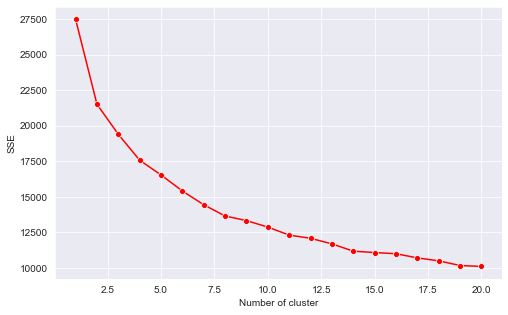

In [78]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.lineplot(x=sse.keys(), y=sse.values(), marker='o', color='red')

plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

(array([192.,   0., 204.,   0., 185.,   0., 184.,   0.,  63.,  88.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

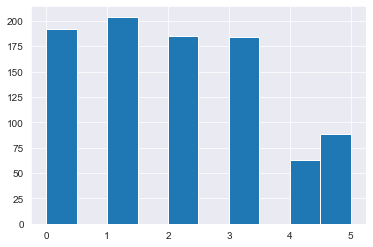

In [79]:
plt.hist(labels[6])

In [80]:
data_merged['label'] = labels[6]

# prediction

### Test Set

In [81]:
data_test_full.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
10786,FF,2021-10-03,92.3,1.40,6.80,"Smith, Will",596019,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5.0,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,NaN,NaN,NaN,2,9,Top,77.54,155.31,NaN,NaN,518595.0,NaN,NaN,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13.0,95.2,-13.0,92.8,2330.0,6.5,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.03,0.174,0.158,0.0,1.0,0.0,0.0,2.0,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148.0,0.000,-0.073
10787,SL,2021-10-03,80.6,1.60,6.64,"Smith, Will",596019,519293,NaN,foul,NaN,NaN,NaN,NaN,4.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,NaN,NaN,1,1,2021,-0.77,0.48,-0.71,2.62,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-3.700232,-117.430885,-3.266842,-6.531123,19.793390,-27.369114,3.32,1.51,108.0,75.3,75.0,81.2,2254.0,6.4,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,Slider,5,0,0,5,0,5,0,5,Infield shift,Strategic,315.0,0.000,-0.027
10788,CU,2021-10-03,75.5,1.46,6.88,"Smith, Will",596019,519293,NaN,foul,NaN,NaN,NaN,NaN,5.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,NaN,NaN,1,0,2021,-0.65,-0.51,-0.04,2.46,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,-1.977183,-109.901781,-1.155694,-4.872924,20.602334,-36.262184,3.32,1.51,157.0,83.5,65.0,75.2,1940.0,6.2,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,Curveball,5,0,0,5,0,5,0,5,Infield shift,Standard,328.0,0.000,-0.020
10789,CU,2021-10-03,75.0,1.53,6.83,"Smith, Will",596019,519293,NaN,ball,NaN,NaN,NaN,NaN,12.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,B,NaN,NaN,0,0,2021,-0.69,-0.69,2.10,3.89,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595.0,NaN,NaN,2.375830,-109.205830,2.277617,-5.902656,19.427562,-38.284747,3.31,1.48,NaN,NaN,NaN,74.5,2017.0,5.9,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,Curveball,5,0,0,5,0,5,0,5,Standard,Standard,330.0,0.000,0.016
10790,FF,2021-10-03,91.2,1.49,6.66,"Smith, Will",607043,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,4.0,"Brandon Nimmo grounds out, second baseman Ozzi...",R,L,L,ATL,NYM,X,4.0,ground_ball,1,0,2021,0.63,1.28,-0.31,2.80,NaN,NaN,NaN,1,9,Top,144.83,145.72,NaN,NaN,518595.0,NaN,NaN,-5.868477,-132.500539,-6.486796,8.700586,30.117690,-15.941174,3.49,1.60,9.0,93.3,-18.0,90.9,2281.0,6.3,632254,519293,518595.0,663586.0,645277.0,501303.0,606115.0,592696.0,628338.0,594807.0,54.15,0.100,0.090,0.0,1.0,0.0,0.0,2.0,60,2,4-Seam Fastball,5,0,0,5,0,5,0,5,Standard,Standard,143.0,0.002,-0.189


In [82]:
test_grouped = data_test_full.groupby(['game_date', 'game_pk', 'at_bat_number']).agg({'home_team':max,
                                                                                      'away_team':max,
                                                                                      'inning_topbot':max,
                                                                                      'inning':max,
                                                                                      'outs_when_up':max,
                                                                                      'player_name':max,
                                                                                      'pitcher':max,
                                                                                      'batter':max,
                                                                                      'events':'first',
                                                                                      'delta_home_win_exp':sum,
                                                                                      'delta_run_exp':sum}).copy()
test_grouped = test_grouped.reset_index()

In [83]:
test_grouped.head()

,game_date,game_pk,at_bat_number,home_team,away_team,inning_topbot,inning,outs_when_up,player_name,pitcher,batter,events,delta_home_win_exp,delta_run_exp
0,2021-09-01,632640,1,TOR,BAL,Top,1,0,"Matz, Steven",571927,656775,field_out,0.022,-0.241
1,2021-09-01,632640,2,TOR,BAL,Top,1,1,"Matz, Steven",571927,663624,single,-0.025,0.263
2,2021-09-01,632640,3,TOR,BAL,Top,1,1,"Matz, Steven",571927,669720,force_out,0.028,-0.384
3,2021-09-01,632640,4,TOR,BAL,Top,1,2,"Matz, Steven",571927,641820,strikeout,0.022,-0.295
4,2021-09-01,632640,5,TOR,BAL,Bot,1,0,"Harvey, Matt",518774,543807,field_out,-0.021,-0.241


In [84]:
test_grouped['events'].unique()

array(['field_out', 'single', 'force_out', 'strikeout', 'home_run',
       'walk', 'grounded_into_double_play', 'double', 'hit_by_pitch',
       'sac_fly_double_play', 'field_error', 'fielders_choice', 'sac_fly',
       'triple', 'fielders_choice_out', 'strikeout_double_play',
       'caught_stealing_2b', None, 'double_play', 'sac_bunt',
       'catcher_interf', 'pickoff_1b', 'other_out', 'pickoff_2b',
       'stolen_base_2b', 'passed_ball', 'wild_pitch',
       'caught_stealing_3b', 'pickoff_3b', 'caught_stealing_home'],
      dtype=object)

### train set

In [226]:
# replace onbase info with 0 and 1s

data_train_full.loc[data_train_full['on_3b'].notna(), 'on_3b'] = 1
data_train_full.loc[data_train_full['on_2b'].notna(), 'on_2b'] = 1
data_train_full.loc[data_train_full['on_1b'].notna(), 'on_1b'] = 1
data_train_full[['on_3b', 'on_2b', 'on_1b']] = data_train_full[['on_3b', 'on_2b', 'on_1b']].fillna(0)

In [237]:
data_train_full.tail()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1802508,NaN,2019-03-20,NaN,NaN,NaN,"Fiers, Mike",571745,571666,NaN,foul,NaN,NaN,NaN,NaN,NaN,Mitch Haniger pops out to first baseman Matt O...,R,R,R,OAK,SEA,S,NaN,NaN,0,2,2019,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1,1,Top,NaN,NaN,NaN,NaN,460026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566083,571666,460026.0,621566.0,595777.0,656305.0,543760.0,640461.0,657656.0,572039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0.000,0.000
1802509,NaN,2019-03-20,NaN,NaN,NaN,"Fiers, Mike",571745,571666,NaN,called_strike,NaN,NaN,NaN,NaN,NaN,Mitch Haniger pops out to first baseman Matt O...,R,R,R,OAK,SEA,S,NaN,NaN,0,1,2019,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1,1,Top,NaN,NaN,NaN,NaN,460026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566083,571666,460026.0,621566.0,595777.0,656305.0,543760.0,640461.0,657656.0,572039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0.000,-0.041
1802510,NaN,2019-03-20,NaN,NaN,NaN,"Fiers, Mike",571745,571666,NaN,called_strike,NaN,NaN,NaN,NaN,NaN,Mitch Haniger pops out to first baseman Matt O...,R,R,R,OAK,SEA,S,NaN,NaN,0,0,2019,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1,1,Top,NaN,NaN,NaN,NaN,460026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566083,571666,460026.0,621566.0,595777.0,656305.0,543760.0,640461.0,657656.0,572039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0.000,-0.030
1802511,NaN,2019-03-20,NaN,NaN,NaN,"Fiers, Mike",543829,571666,field_out,hit_into_play,NaN,NaN,NaN,NaN,NaN,Dee Gordon lines out sharply to right fielder ...,R,L,R,OAK,SEA,X,9.0,line_drive,1,0,2019,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,1,Top,199.0,109.62,NaN,NaN,460026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566083,571666,460026.0,621566.0,595777.0,656305.0,543760.0,640461.0,657656.0,572039.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1,2,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0.022,-0.285
1802512,NaN,2019-03-20,NaN,NaN,NaN,"Fiers, Mike",543829,571666,NaN,ball,NaN,NaN,NaN,NaN,NaN,Dee Gordon lines out sharply to right fielder ...,R,L,R,OAK,SEA,B,NaN,NaN,0,0,2019,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,1,Top,NaN,NaN,NaN,NaN,460026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566083,571666,460026.0,621566.0,595777.0,656305.0,543760.0,640461.0,657656.0,572039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0.000,0.037


In [235]:
train_grouped = data_train_full.groupby(['game_date', 'game_pk', 'at_bat_number']).agg({'home_team':max,
                                                                                      'away_team':max,
                                                                                      'inning_topbot':max,
                                                                                      'inning':max,
                                                                                      'outs_when_up':max,
                                                                                      'on_1b':'last',
                                                                                      'on_2b':'last',
                                                                                      'on_3b':'last',
                                                                                      'player_name':max,
                                                                                      'pitcher':max,
                                                                                      'batter':max,
                                                                                      'events':'first',
                                                                                      'delta_home_win_exp':sum,
                                                                                      'delta_run_exp':sum}).copy()
train_grouped = train_grouped.reset_index()

In [236]:
train_grouped.head() # last

,game_date,game_pk,at_bat_number,home_team,away_team,inning_topbot,inning,outs_when_up,on_1b,on_2b,on_3b,player_name,pitcher,batter,events,delta_home_win_exp,delta_run_exp
0,2019-03-20,566083,1,OAK,SEA,Top,1,0,0.0,0.0,0.0,"Fiers, Mike",571666,543829,field_out,0.022,-0.248
1,2019-03-20,566083,2,OAK,SEA,Top,1,1,0.0,0.0,0.0,"Fiers, Mike",571666,571745,field_out,0.015,-0.177
2,2019-03-20,566083,3,OAK,SEA,Top,1,2,0.0,0.0,0.0,"Fiers, Mike",571666,457803,single,-0.012,0.128
3,2019-03-20,566083,4,OAK,SEA,Top,1,2,1.0,0.0,0.0,"Fiers, Mike",571666,429665,strikeout,0.022,-0.312
4,2019-03-20,566083,5,OAK,SEA,Bot,1,0,0.0,0.0,0.0,"Gonzales, Marco",594835,657656,strikeout,-0.021,-0.249


In [234]:
train_grouped.head()

,game_date,game_pk,at_bat_number,home_team,away_team,inning_topbot,inning,outs_when_up,on_1b,on_2b,on_3b,player_name,pitcher,batter,events,delta_home_win_exp,delta_run_exp
0,2019-03-20,566083,1,OAK,SEA,Top,1,0,0.0,0.0,0.0,"Fiers, Mike",571666,543829,field_out,0.022,-0.248
1,2019-03-20,566083,2,OAK,SEA,Top,1,1,0.0,0.0,0.0,"Fiers, Mike",571666,571745,field_out,0.015,-0.177
2,2019-03-20,566083,3,OAK,SEA,Top,1,2,0.0,0.0,0.0,"Fiers, Mike",571666,457803,single,-0.012,0.128
3,2019-03-20,566083,4,OAK,SEA,Top,1,2,0.0,1.0,0.0,"Fiers, Mike",571666,429665,strikeout,0.022,-0.312
4,2019-03-20,566083,5,OAK,SEA,Bot,1,0,0.0,0.0,0.0,"Gonzales, Marco",594835,657656,strikeout,-0.021,-0.249


In [194]:
data_merged[data_merged['pitcher']==571927]['label']

245    1
Name: label, dtype: int32

In [195]:
pitcher_group1 = data_merged[data_merged['label']==1]['pitcher'].to_list()

In [196]:
delta = train_grouped[train_grouped['pitcher'].isin(pitcher_group1)&(train_grouped['batter']==656775)]['delta_run_exp']

In [197]:
train_grouped[train_grouped['pitcher'].isin(pitcher_group1)&(train_grouped['batter']==656775)]['delta_run_exp'].mean()

0.005637614678899075

(array([ 6., 94., 47., 40., 17.,  9.,  0.,  3.,  1.,  1.]),
 array([-0.8   , -0.4988, -0.1976,  0.1036,  0.4048,  0.706 ,  1.0072,
         1.3084,  1.6096,  1.9108,  2.212 ]),
 <BarContainer object of 10 artists>)

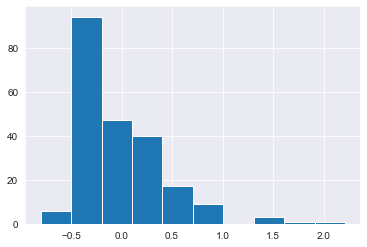

In [198]:
plt.hist(delta)

In [199]:
y_test = test_grouped[(test_grouped['pitcher']==571927)&(test_grouped['batter']==656775)]['delta_run_exp']

In [200]:
y_pred = [-0.005637614678899075 for i in range(9)]

In [201]:
y_test

0       -0.241
13       1.004
29       0.274
11298   -0.241
11311   -0.227
11342   -0.163
30535   -0.241
30550   -0.307
30574   -0.163
Name: delta_run_exp, dtype: float64

In [202]:
sum(abs(y_test - y_pred))/9

0.3147568807339449

# Run Expectancy Matrix of PA Events

In [203]:
# there are about 540 mising values, so fill with 'missing'
train_grouped['events'].fillna('missing', inplace=True)

In [204]:
# drop all missing event rows
train_grouped = train_grouped[train_grouped['events']!='missing'].copy()

In [205]:
PA_full = train_grouped['events'].unique()

In [206]:
PA_fake = ['caught_stealing_2b', 'wild_pitch', 'caught_stealing_home', 'pickoff_1b',
          'catcher_interf', 'caught_stealing_3b', 'pickoff_2b', 'game_advisory',
          'pickoff_caught_stealing_home', 'passed_ball', 'pickoff_caught_stealing_3b', 
          'stolen_base_2b', 'runner_double_play', 'pickoff_3b', 'pickoff_caught_stealing_2b', 'other_out']
len(PA_fake)

16

In [207]:
PA_real = []
for pa in PA_full:
    if pa not in PA_fake:
        PA_real.append(pa)
    else:
        continue

In [208]:
PA_real

['field_out',
 'single',
 'strikeout',
 'home_run',
 'fielders_choice',
 'grounded_into_double_play',
 'hit_by_pitch',
 'walk',
 'double',
 'sac_bunt',
 'sac_fly',
 'force_out',
 'field_error',
 'triple',
 'fielders_choice_out',
 'double_play',
 'strikeout_double_play',
 'sac_bunt_double_play',
 'sac_fly_double_play',
 'triple_play']

In [209]:
PA_fake

['caught_stealing_2b',
 'wild_pitch',
 'caught_stealing_home',
 'pickoff_1b',
 'catcher_interf',
 'caught_stealing_3b',
 'pickoff_2b',
 'game_advisory',
 'pickoff_caught_stealing_home',
 'passed_ball',
 'pickoff_caught_stealing_3b',
 'stolen_base_2b',
 'runner_double_play',
 'pickoff_3b',
 'pickoff_caught_stealing_2b',
 'other_out']

In [210]:
train_grouped.shape

(394964, 14)

In [211]:
train_grouped[train_grouped['events'].isin(PA_real)]['events'].value_counts()

field_out                    153497
strikeout                     92007
single                        54496
walk                          32765
double                        17416
home_run                      13617
force_out                      7800
grounded_into_double_play      7242
hit_by_pitch                   4470
field_error                    2850
sac_fly                        2397
triple                         1537
sac_bunt                       1497
fielders_choice                 875
double_play                     859
fielders_choice_out             627
strikeout_double_play           287
sac_fly_double_play              28
triple_play                      10
sac_bunt_double_play              5
Name: events, dtype: int64

In [212]:
# reduce these PA outcomes into groups
# label PA_fake with other
train_grouped.loc[train_grouped['events'].isin(PA_fake), 'PA_outcome'] = 'other'
train_grouped.loc[train_grouped['events'].isin(PA_real), 'PA_outcome'] = train_grouped['events']

In [213]:
# Group PA_real
train_grouped.loc[train_grouped['events']=='strikeout_double_play'] = 'strikeout'
train_grouped.loc[train_grouped['events']=='force_out'] = 'fielders_choice'
train_grouped.loc[train_grouped['events']=='fielders_choice_out'] = 'fielders_choice'
train_grouped.loc[train_grouped['events']=='double_play'] = 'grounded_into_double_play'
train_grouped.loc[train_grouped['events']=='sac_bunt_double_play'] = 'grounded_into_double_play'
train_grouped.loc[train_grouped['events']=='sac_fly_double_play'] = 'grounded_into_double_play'
train_grouped.loc[train_grouped['events']=='hit_by_pitch'] = 'walk'

In [214]:
train_grouped['PA_outcome'].value_counts()

field_out                    153497
strikeout                     92294
single                        54496
walk                          37235
double                        17416
home_run                      13617
fielders_choice                9302
grounded_into_double_play      8134
field_error                    2850
sac_fly                        2397
triple                         1537
sac_bunt                       1497
other                           682
triple_play                      10
Name: PA_outcome, dtype: int64

In [215]:
train_grouped.head()

,game_date,game_pk,at_bat_number,home_team,away_team,inning_topbot,inning,outs_when_up,player_name,pitcher,batter,events,delta_home_win_exp,delta_run_exp,PA_outcome
0,2019-03-20,566083,1,OAK,SEA,Top,1,0,"Fiers, Mike",571666,543829,field_out,0.022,-0.248,field_out
1,2019-03-20,566083,2,OAK,SEA,Top,1,1,"Fiers, Mike",571666,571745,field_out,0.015,-0.177,field_out
2,2019-03-20,566083,3,OAK,SEA,Top,1,2,"Fiers, Mike",571666,457803,single,-0.012,0.128,single
3,2019-03-20,566083,4,OAK,SEA,Top,1,2,"Fiers, Mike",571666,429665,strikeout,0.022,-0.312,strikeout
4,2019-03-20,566083,5,OAK,SEA,Bot,1,0,"Gonzales, Marco",594835,657656,strikeout,-0.021,-0.249,strikeout


In [216]:
data_train_full[data_train_full['events']=='home_run']

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
141773,FF,2021-08-31,96.7,-3.05,5.89,"López, Jorge",665489,605347,home_run,hit_into_play,NaN,NaN,NaN,NaN,5.0,Vladimir Guerrero homers (39) on a fly ball to...,R,R,R,TOR,BAL,X,NaN,fly_ball,1,0,2021,-0.53,1.24,-0.27,2.76,1.0,1.0,1.0,0,6,Bot,201.50,66.26,NaN,NaN,600474.0,NaN,NaN,8.596336,-140.357686,-5.492877,-9.154256,36.072896,-14.778695,3.47,1.59,377.0,103.3,26.0,95.9,2024.0,6.3,632715,605347,600474.0,663624.0,663330.0,602104.0,622761.0,663630.0,656775.0,669720.0,54.23,0.846,1.545,2.0,1.0,0.0,3.0,6.0,45,2,4-Seam Fastball,1,3,1,3,3,2,2,3,Standard,Standard,216.0,0.139,0.962
141873,FF,2021-08-31,92.2,2.30,6.07,"Akin, Keegan",643376,669211,home_run,hit_into_play,NaN,NaN,NaN,NaN,2.0,Danny Jansen homers (6) on a fly ball to left ...,R,R,L,TOR,BAL,X,NaN,fly_ball,0,1,2021,0.81,1.39,0.04,3.01,1.0,1.0,1.0,0,3,Bot,60.27,36.79,NaN,NaN,600474.0,NaN,NaN,-7.402716,-133.994195,-4.839121,11.417645,32.542785,-14.593286,3.47,1.59,431.0,106.6,29.0,90.5,2284.0,5.6,632715,669211,600474.0,663624.0,663330.0,602104.0,622761.0,663630.0,656775.0,669720.0,54.89,0.951,1.904,2.0,1.0,0.0,3.0,6.0,20,2,4-Seam Fastball,0,0,0,0,0,1,1,0,Standard,Standard,145.0,0.119,1.038
142011,FF,2021-08-31,92.8,-0.04,6.04,"Thielbar, Caleb",664023,573204,home_run,hit_into_play,NaN,NaN,NaN,NaN,1.0,Ian Happ homers (17) on a fly ball to left field.,R,R,L,MIN,CHC,X,NaN,fly_ball,3,2,2021,0.59,1.50,-0.32,3.25,1.0,1.0,1.0,2,8,Top,10.31,63.56,NaN,NaN,680777.0,NaN,NaN,-2.021875,-135.070426,-4.650347,7.630538,29.491123,-12.993221,3.37,1.53,437.0,110.0,30.0,92.9,2345.0,6.3,632694,573204,680777.0,593934.0,650333.0,518626.0,624503.0,595909.0,621439.0,596146.0,54.18,0.986,1.981,2.0,1.0,0.0,3.0,6.0,57,9,4-Seam Fastball,1,2,2,1,3,1,3,1,Standard,Standard,164.0,-0.135,0.970
142268,SI,2021-08-31,92.5,-2.82,5.85,"Gant, John",643524,607231,home_run,hit_into_play,NaN,NaN,NaN,NaN,8.0,Frank Schwindel homers (7) on a fly ball to ce...,R,R,R,MIN,CHC,X,NaN,fly_ball,0,0,2021,-1.34,1.12,0.03,1.69,1.0,1.0,1.0,1,1,Top,105.52,30.00,NaN,NaN,666163.0,NaN,NaN,10.152713,-134.210606,-7.174099,-18.442352,29.090216,-17.228964,3.41,1.56,421.0,104.6,27.0,92.1,2431.0,6.2,632694,607231,666163.0,593934.0,650333.0,518626.0,592743.0,667670.0,621439.0,596146.0,54.29,0.911,1.784,2.0,1.0,0.0,3.0,6.0,2,1,Sinker,0,0,0,0,1,0,1,0,Standard,Standard,226.0,-0.103,1.000
142291,KC,2021-08-31,82.3,2.75,6.01,"Holland, Derek",656305,502706,home_run,hit_into_play,NaN,NaN,NaN,NaN,6.0,Matt Chapman homers (23) on a fly ball to cent...,R,R,L,DET,OAK,X,NaN,fly_ball,0,1,2021,0.11,0.37,0.63,2.21,1.0,1.0,1.0,2,9,Top,89.97,30.04,NaN,NaN,572863.0,NaN,NaN,-4.998708,-119.878830,-2.893737,1.982172,20.930983,-28.241950,3.37,1.53,426.0,108.3,26.0,82.3,2046.0,6.0,632688,502706,572863.0,408234.0,570731.0,600869.0,670097.0,650489.0,656537.0,543257.0,54.48,0.963,1.899,2.0,1.0,0.0,3.0,6.0,74,2,Knuckle Curve,3,8,8,3,9,3,9,3,Standard,Standard,142.0,-0.003,1.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...